## U shape PHP dynamics with multiple liquid slugs - with heat transfer

## $\frac{\partial \theta }{\partial \mathcal{T}} = \nabla^2 \theta$

In [1]:
@time using Plots
pyplot()

 16.086204 seconds (19.47 M allocations: 1.001 GiB, 3.23% gc time)


Plots.PyPlotBackend()

In [2]:
@time using DifferentialEquations

 43.742965 seconds (61.50 M allocations: 3.411 GiB, 3.04% gc time)


In [3]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing

cd(dirname(pwd()))
cd("src") 

In [4]:
function nucleateboiling(sys,Xvapornew,Pinsert)
    ρ = deepcopy(sys.liquid.ρ)
    d = deepcopy(sys.tube.d)
    Xp = deepcopy(sys.liquid.Xp)
    dXdt = deepcopy(sys.liquid.dXdt)
    δ = deepcopy(sys.vapor.δ)
    P = deepcopy(sys.vapor.P)
    L = sys.tube.L
    γ = sys.vapor.γ
    Xarrays = sys.liquid.Xarrays
    θarrays = sys.liquid.θarrays

    Lvaporplug =    XptoLvaporplug(Xp,sys.tube.L)
    M = P.^(1/γ).* Lvaporplug







    # Xvapornew = (1.50,1.60)
    # Pinsert = 1.5
    ρinsert = Pinsert.^(1/γ)
    Linsert = Xvapornew[end] - Xvapornew[1]
    Minsert = Pinsert.^(1/γ).* Linsert

    index = getinsertindex(Xp,Xvapornew)
    δnew = getnewδ(δ,index,Xvapornew,ρ,d,Minsert) # mass conservation
    Xpnew = getnewXp(Xp,index,Xvapornew)
    Mnew = getnewM(M,index,Minsert)

    Lvaporplugnew = XptoLvaporplug(Xpnew,L)
    Pnew = (Mnew./Lvaporplugnew).^γ

    Xarraysnew = getnewXarrays(index,Xp,Xpnew,Xarrays,L)
    θarraysnew = getnewθarrays(index,Xp,Xpnew,Xarrays,θarrays,L)

    dXdtnew = deepcopy(dXdt) # momentum conservation
    insert!(dXdtnew,index+1,dXdtnew[index])






    sysnew = deepcopy(sys)

    sysnew.liquid.Xp = Xpnew
    sysnew.liquid.dXdt = dXdtnew
    sysnew.liquid.Xarrays = Xarraysnew
    sysnew.liquid.θarrays = θarraysnew
    sysnew.vapor.P = Pnew
    sysnew.vapor.δ = δnew

    walltoliquid, liquidtowall = constructmapping(sysnew.liquid.Xarrays ,sysnew.wall.Xarray)
    sysnew.mapping = Mapping(walltoliquid,liquidtowall)

return sysnew
end

nucleateboiling (generic function with 1 method)

In [5]:
function getnewδ(δ,index,Xvapornew,ρ,d,Minsert)
    Linsert = Xvapornew[end] - Xvapornew[1]

    crossAfilms = getcrossAδ.([d],δ)
    insertcrossA = 0.5(crossAfilms[index] + crossAfilms[index+1]) - Minsert/ρ/Linsert
    insert!(crossAfilms,index+1,insertcrossA)

    δnew = crossAtoδ.([d],crossAfilms)
end

getnewδ (generic function with 1 method)

In [6]:
function crossAtoδ(d,crossA)
    C = crossA # nondimensional area
    δ = 1 - sqrt(1-C)
end


crossAtoδ (generic function with 1 method)

In [7]:
function getcrossAδ(d,δ)
    crossAouter = 1
    crossAinner = (1-δ)^2
    crossAδ     = crossAouter - crossAinner
end


getcrossAδ (generic function with 1 method)

In [8]:

 function getnewθarrays(index,Xp,Xpnew,Xarrays,θarrays,L)
    θarraysnew = deepcopy(θarrays)
    Xarraysnew = deepcopy(Xarrays)
    arrayindex = getarrayindex(Xpnew[index][2],Xarrays[index])

    θarraysnewleft = θarrays[index][1:arrayindex]
    θarraysnewright= θarrays[index][arrayindex+1:end]

    splice!(θarraysnew, index)
    insert!(θarraysnew, index,θarraysnewleft)
    insert!(θarraysnew, index+1,θarraysnewright)
end

getnewθarrays (generic function with 1 method)

In [9]:

function getnewXarrays(index,Xp,Xpnew,Xarrays,L)
    Xarraysnew = deepcopy(Xarrays)
    arrayindex = getarrayindex(Xpnew[index][2],Xarrays[index])

    Xarraysnewleft = LinRange(Xpnew[index][1],Xpnew[index][2],arrayindex)
    Xarraysnewright= LinRange(Xpnew[index+1][1],Xpnew[index+1][2],length(Xarrays[index])-arrayindex)

    splice!(Xarraysnew, index)
    insert!(Xarraysnew, index,Xarraysnewleft)
    insert!(Xarraysnew, index+1,Xarraysnewright)
end

getnewXarrays (generic function with 1 method)

In [10]:
function getinsertindex(Xp,Xvapornew)

for index = 1:length(Xp)
    if Xp[index][1] <= Xvapornew[1] && Xp[index][2] >= Xvapornew[2]
        return index
end
    end
        return NaN
end

getinsertindex (generic function with 1 method)

In [11]:
function getarrayindex(X,Xarray)

for arrayindex = 1:length(Xarray)
    if X >= Xarray[arrayindex] && X <= Xarray[arrayindex+1]
        return arrayindex
end
    end
        return NaN
end

getarrayindex (generic function with 1 method)

In [12]:
function getnewXp(Xp,index,Xvapornew)
    
    Xpnew = deepcopy(Xp)
    
    Linsert = Xvapornew[end] - Xvapornew[1]
        
    insertXp1=(Xp[index][1]-Linsert/2,Xvapornew[1])
    insertXp2=(Xvapornew[2],Xp[index][2]+Linsert/2)

    splice!(Xpnew, index)
    insert!(Xpnew, index,insertXp1)
    insert!(Xpnew, index+1,insertXp2)
    
    return Xpnew
end

getnewXp (generic function with 1 method)

In [13]:
function getnewδ(δ,Pinsert,index,Xvapornew)
    
    Linsert = Xvapornew[end] - Xvapornew[1]
    δnew = deepcopy(δ)
    
    δavg = (δ[index]+δ[index+1])/2
    insert!(δnew, index+1,δavg)
    
    return δnew
end

getnewδ (generic function with 2 methods)

In [14]:
function getnewM(M,index,Minsert)
    
    Mnew = deepcopy(M)
    
    insert!(Mnew,index+1,Minsert)
    
    return Mnew
end

getnewM (generic function with 1 method)

In [15]:
function newvaporbubble(sys)
    Xp = sys.liquid.Xp
    dXdt = sys.liquid.dXdt
    P = sys.vapor.P
    
    Lvaporplug = XptoLvaporplug(X0,sys.tube.L)
    M = P.^(1/γ).* Lvaporplug

    δ = sys.vapor.δ
    
    
    index = getinsertindex(Xp,Xvapornew)

    modifyδ!(δ,index,Xvapornew)

    insertXvapor!(Xp,index,Xvapornew)

    
end

newvaporbubble (generic function with 1 method)

In [16]:
XMδtovec(X0,dXdt0,M,δ)

UndefVarError: UndefVarError: X0 not defined

In [17]:
function XMδtovec(Xp,dXdt,M,δ)
    
    return ([XMtovec(Xp,dXdt,M);δ])
end

ErrorException: error in method definition: function Tools.XMδtovec must be explicitly imported to be extended

## Parameters of the PHP

In [18]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];

    θinitial=1.0
    θ  = 0.15;
    θe = 1 + θ;
    θc = 1 - θ;
    
    He = 3000.0;
    Hc = 3000.0;
    Hₗ =  3000.0; # liquid wall heat transfer coeffcient

    
    X0 = 0.5;

    γ = 1.4;

In [19]:
    
    d = 1/30 # dimensionless diameter
    L = 8.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    angle = pi/2 # inclination angle 


1.5707963267948966

## Pipe definition

In [20]:
tube = Tube(d,L,L2D,angle)

Tube(0.03333333333333333, 8.0, 2.0, 1.5707963267948966)

## Evaporator and condenser definition

In [21]:
Xe = map(tuple, [0.0; 3.0; 7.0], [1.0; 5.0; 8.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)])

In [22]:
Xc = map(tuple, [1.0; 5.0], [3.0; 7.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)])

## Vapor plug and liquid slug initialization

In [23]:
N=1000
X0 = [(0.5,2.5),(5.0,7.0)]
dXdt0 = [(0.0,0.0),(0.0,0.0)]
ρₗ = 1000
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(γ,Hₗ,ρₗ,ω0,℘,X0,dXdt0,Xarrays,θarrays)

Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5], [5.0, 5.008032128514056, 5.016064257028113, 5.024096385542169, 5.032128514056225, 5.040160642570281, 5.048192771084337, 5.056224899598393, 5.06425702811245, 5.072289156626506  …  6.927710843373494, 6.93574297188755, 6.943775100401607, 6.951807228915663, 6.959839357429719, 6.967871485943775, 6.975903614457831, 6.983935742971887, 6.991967871485944, 7.0]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [24]:
P = [1.0,1.0,1.0];
δ = 0.05*P;
vapors=Vapor(γ,P,δ)

Vapor(1.4, [1.0, 1.0, 1.0], [0.05, 0.05, 0.05])

In [25]:
α = 1 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)

wall = Wall(α,Xwallarray,θwallarray)

Wall(1.0, [0.0, 0.008008008008008008, 0.016016016016016016, 0.024024024024024024, 0.03203203203203203, 0.04004004004004004, 0.04804804804804805, 0.056056056056056056, 0.06406406406406406, 0.07207207207207207  …  7.927927927927928, 7.935935935935936, 7.943943943943944, 7.951951951951952, 7.95995995995996, 7.967967967967968, 7.975975975975976, 7.983983983983984, 7.991991991991992, 8.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [26]:
# struct Mapping
#     walltoliquid::Array{Tuple{Int64,Int64},1}
#     liquidtowall::Array{Array{Int64,1},1}
# end

In [27]:
walltoliquid, liquidtowall = constructmapping(Xarrays,Xwallarray)
mapping = Mapping(walltoliquid,liquidtowall)

Mapping(Tuple{Int64,Int64}[(1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1)  …  (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1)], Array{Int64,1}[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73  …  305, 306, 307, 308, 309, 310, 311, 312, 313, 314], [626, 627, 628, 629, 630, 631, 632, 633, 634, 635  …  867, 868, 869, 870, 871, 872, 873, 874, 875, 876]])

## Construct the system

In [28]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping)

PHPSystem(Tube(0.03333333333333333, 8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5], [5.0, 5.008032128514056, 5.016064257028113, 5.024096385542169, 5.032128514056225, 5.040160642570281, 5.048192771084337, 5.056224899598393, 5.06425702811245, 5.072289156626506  …  6.927710843373494, 6.93574297188755, 6.9437751004

In [29]:
typeof(sys0)

PHPSystem

## Construct U for wall heat function

## construct state vector U

In [30]:
vectoXMδ(XMδtovec(X0,dXdt0,M,δ))

UndefVarError: UndefVarError: M not defined

In [31]:
sys0.wall.θarray = settemperature!.(sys0.wall.θarray,sys0.wall.Xarray,[sys0]);

In [32]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L)
M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); wallθtovec(sys0.wall.θarray); liquidθtovec(sys0.liquid.θarrays)];

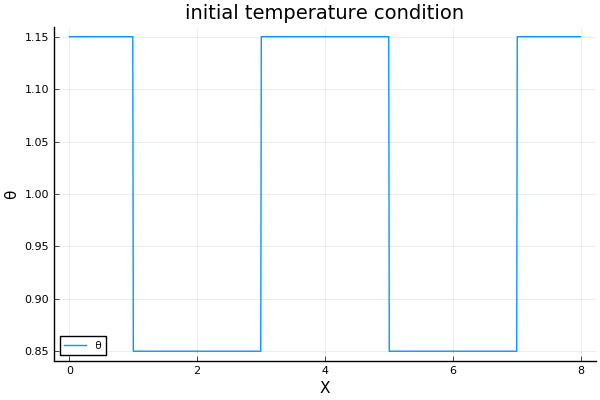

In [33]:
plot([sys0.wall.Xarray],[sys0.wall.θarray], title="initial temperature condition", labels = "θ", xlabel="X", ylabel="θ")

## Solve the constructed ODE for U

### propagation function

In [117]:
function dfdt(u,p,t)


#            print(p.vapor,"\n")
#     print(p.tube,"\n")
#     print(p.liquid,"\n")
#     print(p.wall,"\n")
#     print(p.mapping,"\n")
#     print(u[1:18],"\n")
    
        p = deepcopy(getcurrentsys(u,p))
    
        indexes = Int64[]
        θliquidtemp = Array[]

        for i = 1:length(u)
            if abs(u[i]+1e10) <= 10^(-1)
                push!(indexes,i)
            end
        end
    

    dynamicsdu = dynamicsmodel(u[1:indexes[1]-1],p)
    
    
    
    duwalltemp = wallmodel(u[indexes[1]+1:indexes[2]-1],p)
    walldu = duwallθtovec(duwalltemp)
    
    
    
    for i = 1:length(indexes)-2
    push!(θliquidtemp, u[indexes[i+1]+1:indexes[i+2]-1])
    end
    push!(θliquidtemp, u[indexes[end]+1:end])
    duliquidtemp = zero.(deepcopy(θliquidtemp))
    duliquidtemp = liquidmodel(θliquidtemp,p)
    liquiddu = duliquidθtovec(duliquidtemp)
    
    du = [dynamicsdu;walldu;liquiddu]

    return(du)

end

dfdt (generic function with 1 method)

### condition

In [118]:
# function condition(u,t,integrator)
#     return (integrator.t > 0.1)
# end

### affect! (with boundary conditions)

In [135]:
p

PHPSystem(Tube(0.03333333333333333, 8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5], [5.0, 5.008032128514056, 5.016064257028113, 5.024096385542169, 5.032128514056225, 5.040160642570281, 5.048192771084337, 5.056224899598393, 5.06425702811245, 5.072289156626506  …  6.927710843373494, 6.93574297188755, 6.9437751004

In [136]:
function affect!(integrator)
    
    p = deepcopy(getcurrentsys(integrator.u,integrator.p))
    
    p = nucleateboiling(p,(1.2,1.4),1.0)
    
    Lvaporplug = XptoLvaporplug(p.liquid.Xp,p.tube.L)
    M = p.vapor.P.^(1/p.vapor.γ).* Lvaporplug
    
    unew=[XMδtovec(p.liquid.Xp,p.liquid.dXdt,M,p.vapor.δ); wallθtovec(p.wall.θarray); liquidθtovec(p.liquid.θarrays)];
        
#     set_u!(integrator,  unew)
    resize!(integrator.u,length(unew))
    integrator.u = deepcopy(unew)
    

end

affect! (generic function with 1 method)

In [137]:
cb =  PresetTimeCallback(0.1,affect!)

DiscreteCallback{DiffEqCallbacks.var"#61#64"{Float64},DiffEqCallbacks.var"#62#65"{typeof(affect!)},DiffEqCallbacks.var"#63#66"{typeof(DiffEqBase.INITIALIZE_DEFAULT),Bool,Float64,typeof(affect!)}}(DiffEqCallbacks.var"#61#64"{Float64}(0.1), DiffEqCallbacks.var"#62#65"{typeof(affect!)}(affect!), DiffEqCallbacks.var"#63#66"{typeof(DiffEqBase.INITIALIZE_DEFAULT),Bool,Float64,typeof(affect!)}(DiffEqBase.INITIALIZE_DEFAULT, true, 0.1, affect!), Bool[1, 1])

In [138]:
tstep=4e-5

p = sys0
tspan = (0.0, 0.2);
prob = ODEProblem(dfdt, u, tspan, p)

integrator = init(prob, RK4(), adaptive=false, dt=tstep);


# sol = solve(prob, RK4(), adaptive=false, dt=tstep);
sol = solve(prob, RK4(), adaptive=false,dt=tstep,callback=cb);

In [139]:
sol[end]

1524-element Array{Float64,1}:
  0.6022926684058075 
  1.2898447191243454 
  1.3541865835247635 
  2.6666345328062406 
  4.953079480348319  
  6.953079480348319  
  0.4724651088878505 
  0.4724651088878505 
 -0.3113169283168327 
 -0.3113169283168327 
 -0.19374290276065617
 -0.19374290276065617
  0.6179937965793046 
  ⋮                  
  1.0018980933346642 
  1.0027633969085143 
  1.0036313920655098 
  1.0045020077827334 
  1.0053751790683523 
  1.0062508474625045 
  1.0071289615326977 
  1.008009477355671  
  1.00889235897854   
  1.009777578853822  
  1.0106651182456365 
  1.01155496760805   

In [140]:
constructmapping(Xarrays,Xwallarray)

(Tuple{Int64,Int64}[(1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1)  …  (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1)], Array{Int64,1}[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73  …  305, 306, 307, 308, 309, 310, 311, 312, 313, 314], [626, 627, 628, 629, 630, 631, 632, 633, 634, 635  …  867, 868, 869, 870, 871, 872, 873, 874, 875, 876]])

In [159]:
sysfinal = getcurrentsys.(sol.u,[sys0])

ErrorException: type Array has no field Xarray

In [170]:
sysfinal[end].liquid.Xarrays

3-element Array{Array{Float64,1},1}:
 [0.6022926684058075, 0.6117111896485272, 0.6211297108912469, 0.6305482321339667, 0.6399667533766863, 0.649385274619406, 0.6588037958621257, 0.6682223171048455, 0.6776408383475652, 0.6870593595902847  …  1.205078027939868, 1.2144965491825879, 1.2239150704253074, 1.2333335916680273, 1.2427521129107468, 1.2521706341534666, 1.2615891553961862, 1.271007676638906, 1.2804261978816256, 1.2898447191243454]
 [1.3541865835247635, 1.3616862860920864, 1.369185988659409, 1.3766856912267316, 1.3841853937940543, 1.3916850963613772, 1.3991847989287, 1.4066845014960225, 1.4141842040633452, 1.4216839066306681  …  2.599137209700336, 2.6066369122676587, 2.6141366148349814, 2.6216363174023045, 2.6291360199696268, 2.6366357225369494, 2.6441354251042726, 2.6516351276715953, 2.659134830238918, 2.6666345328062406]   
 [4.953079480348319, 4.9611116088623755, 4.969143737376432, 4.977175865890487, 4.985207994404544, 4.9932401229186, 5.001272251432657, 5.0093043799467125, 5.017

In [141]:
result1=soltoMatrxResult(sol,sys0);

In [142]:
@gif for i=1:size(sol,2)
plot([x],[sol[i][13:1012]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along the wall"), ylim=(0.85,1.15))
    vline!([0,1,3,5,7,8], color = [:red])
    end every 50

UndefVarError: UndefVarError: x not defined

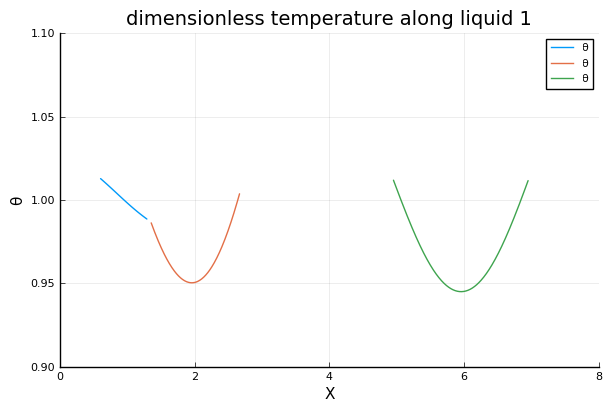

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\OneDThermalFlow\src\tmp.gif
└ @ Plots C:\Users\liyux\.juliapro\JuliaPro_v1.3.1-2\packages\Plots\ninUP\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\OneDThermalFlow\\src\\tmp.gif")
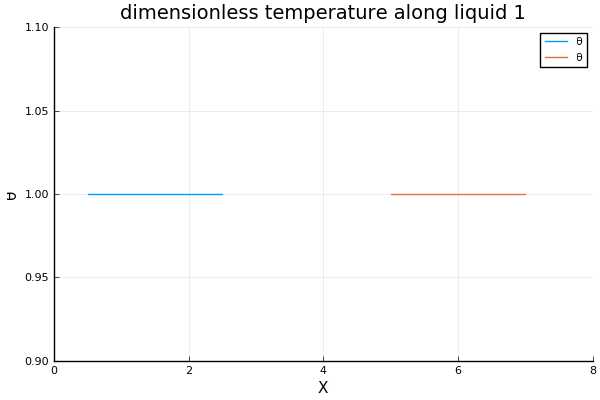

In [175]:
@gif for i=1:size(sol,2)
plot([sysfinal[i].liquid.Xarrays[1]],[sysfinal[i].liquid.θarrays[1]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along liquid 1"),xlim=(0,8), ylim=(0.9,1.1))
plot!([sysfinal[i].liquid.Xarrays[2]],[sysfinal[i].liquid.θarrays[2]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along liquid 1"),xlim=(0,8), ylim=(0.9,1.1))
    if i >2502
        plot!([sysfinal[i].liquid.Xarrays[3]],[sysfinal[i].liquid.θarrays[3]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along liquid 1"),xlim=(0,8), ylim=(0.9,1.1))
    end
    end every 50

In [144]:
# MatrxXp, MatrxdXdt, MatrxM, Matrxδ=soltoMatrxResult(sol[1:2502],sys0);

# ΔMatrxXp = zeros(size(MatrxXp,1)+1,size(MatrxXp,2))
# ΔMatrxXp[1,:] = MatrxXp[1,:]
# ΔMatrxXp[end,:] .= sys0.tube.L .- MatrxXp[end,:]
# for i = 2:size(MatrxXp,1)
#     ΔMatrxXp[i,:] = MatrxXp[i,:]-MatrxXp[i-1,:]
# end

# MatrxXp

In [145]:
MatrxXp1, MatrxdXdt1, MatrxM1, Matrxδ1=soltoMatrxResult(sol[1:2502],sys0);

ΔMatrxXp1 = zeros(size(MatrxXp1,1)+1,size(MatrxXp1,2))
ΔMatrxXp1[1,:] = MatrxXp1[1,:]
ΔMatrxXp1[end,:] .= sys0.tube.L .- MatrxXp1[end,:]
for i = 2:size(MatrxXp1,1)
    ΔMatrxXp1[i,:] = MatrxXp1[i,:]-MatrxXp1[i-1,:]
end

ΔMatrxXp1

5×2502 Array{Float64,2}:
 0.5  0.500005  0.500019  0.500043  0.500077  …  0.612406  0.612448  0.612448
 2.0  2.0       2.0       2.0       2.0          2.0       2.0       2.0     
 2.5  2.5       2.49998   2.49996   2.49992      2.33897   2.3389    2.3389  
 2.0  2.0       2.0       2.0       2.0          2.0       2.0       2.0     
 1.0  1.0       1.0       1.0       1.0          1.04862   1.04865   1.04865 

In [146]:
MatrxXp2, MatrxdXdt2, MatrxM2, Matrxδ2=soltoMatrxResult(sol[2503:end],sys0);

ΔMatrxXp2 = zeros(size(MatrxXp2,1)+1,size(MatrxXp2,2))
ΔMatrxXp2[1,:] = MatrxXp2[1,:]
ΔMatrxXp2[end,:] .= sys0.tube.L .- MatrxXp2[end,:]
for i = 2:size(MatrxXp2,1)
    ΔMatrxXp2[i,:] = MatrxXp2[i,:]-MatrxXp2[i-1,:]
end

ΔMatrxXp2

7×2501 Array{Float64,2}:
 0.512448  0.512526  0.512675  0.512895  …  0.602251   0.602273   0.602293 
 0.687552  0.687552  0.687552  0.687552     0.687552   0.687552   0.687552 
 0.2       0.199949  0.199796  0.199542     0.0644059  0.0643735  0.0643419
 1.31245   1.31245   1.31245   1.31245      1.31245    1.31245    1.31245  
 2.2389    2.23884   2.23883   2.23887      2.28643    2.28644    2.28644  
 2.0       2.0       2.0       2.0       …  2.0        2.0        2.0      
 1.04865   1.04868   1.0487    1.0487       1.04691    1.04691    1.04692  

In [147]:
MatrxXp1

4×2502 Array{Float64,2}:
 0.5  0.500005  0.500019  0.500043  0.500077  …  0.612406  0.612448  0.612448
 2.5  2.5       2.50002   2.50004   2.50008      2.61241   2.61245   2.61245 
 5.0  5.0       5.0       5.0       5.0          4.95138   4.95135   4.95135 
 7.0  7.0       7.0       7.0       7.0          6.95138   6.95135   6.95135 

In [148]:
MatrxXp2

6×2501 Array{Float64,2}:
 0.512448  0.512526  0.512675  0.512895  …  0.602251  0.602273  0.602293
 1.2       1.20008   1.20023   1.20045      1.2898    1.28982   1.28984 
 1.4       1.40003   1.40002   1.39999      1.35421   1.3542    1.35419 
 2.71245   2.71247   2.71247   2.71244      2.66666   2.66665   2.66663 
 4.95135   4.95132   4.9513    4.9513       4.95309   4.95309   4.95308 
 6.95135   6.95132   6.9513    6.9513    …  6.95309   6.95309   6.95308 

In [149]:
length(sol.t[2503:end])

2501

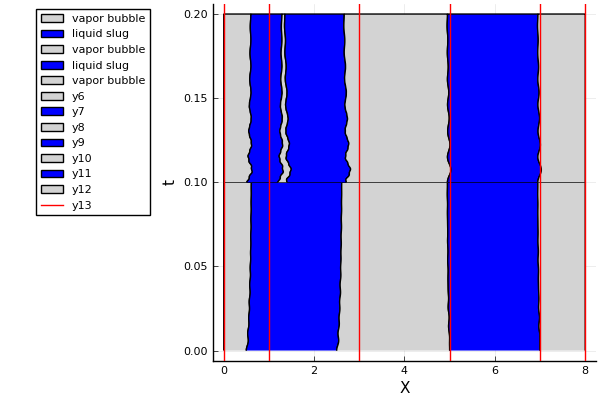

In [154]:
portfoliocomposition(ΔMatrxXp1', sol.t[1:2502], legend = :outertopleft, color = [:lightgrey :blue],ylabel="t", xlabel="X", labels = ["vapor bubble" "liquid slug"])
portfoliocomposition!(ΔMatrxXp2',sol.t[2503:end], color = [:lightgrey :blue])
vline!([0,1,3,5,7,8], color = [:red])

In [176]:
# portfoliocomposition(MatrxM', sol.t, legend = :outertopleft, labels = ("mass of vapor bubble"), ylabel="t", xlabel="mass")

In [172]:
# result1 = soltoResult(sol[1:11,:],sys0)
# plot(sol.t, result1.θ[1], title="temperatures for three vapor bubbles")
# plot!(sol.t, result1.θ[2])
# plot!(sol.t, result1.θ[3])

In [178]:
Xpvapornew = (1.5,1.6)
Pvapornew = 1.1

1.1

In [179]:
sysnew = nucleateboiling(sys0,Xpvapornew,Pvapornew)

PHPSystem(Tube(0.03333333333333333, 8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.44999999999999996, 1.5), (1.6, 2.55), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.44999999999999996, 0.45846774193548384, 0.46693548387096767, 0.47540322580645156, 0.48387096774193544, 0.49233870967741933, 0.5008064516129032, 0.5092741935483871, 0.5177419354838709, 0.5262096774193548  …  1.4237903225806452, 1.432258064516129, 1.440725806451613, 1.4491935483870968, 1.4576612903225805, 1.4661290322580645, 1.4745967741935486, 1.4830645161290323, 1.491532258064516, 1.5], [1.6, 1.6076612903225806, 1.6153225806451612, 1.6229838709677422, 1.6306451612903228, 1.6383064516129033, 1.645967741935484, 1.6536290322580647, 1.6612903225806455, 

In [181]:
sys0.vapor.δ

3-element Array{Float64,1}:
 0.05
 0.05
 0.05